# NLU Assignment 3: Machine Translation Model

Name: Muhammad Fahad Waqar<br>
Student No: st125981

## Task 1: Dataset and Preprocessing

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import math
import time
from collections import Counter

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Dataset class for parallel corpus
class ParallelDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def load_data(file_path):
    english_sentences = []
    urdu_sentences = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                english_sentences.append(parts[0].strip())
                urdu_sentences.append(parts[1].strip())
    
    return list(zip(english_sentences, urdu_sentences))

def simple_tokenize(text):
    return text.split()

def build_vocab(sentences, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        tokens = simple_tokenize(sentence)
        counter.update(tokens)
    
    # Special tokens
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    
    # Add words that appear at least min_freq times
    idx = len(vocab)
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

def process_sentence(sentence, vocab):
    tokens = simple_tokenize(sentence)
    ids = tokens_to_ids(tokens, vocab)
    return [vocab['<sos>']] + ids + [vocab['<eos>']]

def collate_fn_attention(batch, src_vocab, trg_vocab):
    src_batch = []
    trg_batch = []
    src_lengths = []
    
    for src_text, trg_text in batch:
        src_ids = process_sentence(src_text, src_vocab)
        trg_ids = process_sentence(trg_text, trg_vocab)
        
        src_batch.append(torch.tensor(src_ids, dtype=torch.long))
        trg_batch.append(torch.tensor(trg_ids, dtype=torch.long))
        src_lengths.append(len(src_ids))
    
    src_batch = pad_sequence(src_batch, padding_value=src_vocab['<pad>'])
    trg_batch = pad_sequence(trg_batch, padding_value=trg_vocab['<pad>'])
    src_lengths = torch.tensor(src_lengths, dtype=torch.long)
    
    return src_batch, src_lengths, trg_batch

def collate_fn_transformer(batch, src_vocab, trg_vocab):
    src_batch = []
    trg_batch = []
    
    for src_text, trg_text in batch:
        src_ids = process_sentence(src_text, src_vocab)
        trg_ids = process_sentence(trg_text, trg_vocab)
        
        src_batch.append(torch.tensor(src_ids, dtype=torch.long))
        trg_batch.append(torch.tensor(trg_ids, dtype=torch.long))
    
    src_batch = pad_sequence(src_batch, padding_value=src_vocab['<pad>'])
    trg_batch = pad_sequence(trg_batch, padding_value=trg_vocab['<pad>'])
    
    return src_batch, trg_batch

In [3]:
# Load and prepare data
data_path = 'data/urdu20.txt'

print("Loading data...")
data = load_data(data_path)
print(f"Total sentence pairs: {len(data)}")

# Shuffle data
random.shuffle(data)

# Split data: 70% train, 20% validation, 10% test
total = len(data)
train_size = int(total * 0.7)
val_size = int(total * 0.2)

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

print(f"\nData splits:")
print(f"  Train: {len(train_data)}")
print(f"  Val:   {len(val_data)}")
print(f"  Test:  {len(test_data)}")

# Build vocabularies from training data only
print("\nBuilding vocabularies...")
train_src = [pair[0] for pair in train_data]
train_trg = [pair[1] for pair in train_data]

src_vocab = build_vocab(train_src, min_freq=2)
trg_vocab = build_vocab(train_trg, min_freq=2)

print(f"  English vocab size: {len(src_vocab)}")
print(f"  Urdu vocab size:    {len(trg_vocab)}")

# Show sample
print(f"\nSample sentence pair:")
print(f"  EN: {train_data[0][0]}")
print(f"  UR: {train_data[0][1]}")

Loading data...
Total sentence pairs: 10503

Data splits:
  Train: 7352
  Val:   2100
  Test:  1051

Building vocabularies...
  English vocab size: 1791
  Urdu vocab size:    1724

Sample sentence pair:
  EN: I like to swim.
  UR: مجھے تیراکی پسند ہے۔


In [4]:
# Create DataLoaders for Attention models
batch_size = 64

train_dataset = ParallelDataset(train_data)
val_dataset = ParallelDataset(val_data)
test_dataset = ParallelDataset(test_data)

# DataLoaders for Seq2Seq + Attention
train_loader_attn = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=lambda batch: collate_fn_attention(batch, src_vocab, trg_vocab)
)

val_loader_attn = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    collate_fn=lambda batch: collate_fn_attention(batch, src_vocab, trg_vocab)
)

test_loader_attn = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    collate_fn=lambda batch: collate_fn_attention(batch, src_vocab, trg_vocab)
)

# DataLoaders for Transformer
train_loader_transformer = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=lambda batch: collate_fn_transformer(batch, src_vocab, trg_vocab)
)

val_loader_transformer = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    collate_fn=lambda batch: collate_fn_transformer(batch, src_vocab, trg_vocab)
)

test_loader_transformer = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    collate_fn=lambda batch: collate_fn_transformer(batch, src_vocab, trg_vocab)
)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader_attn)}")
print(f"  Val batches:   {len(val_loader_attn)}")
print(f"  Test batches:  {len(test_loader_attn)}")

DataLoaders created:
  Train batches: 115
  Val batches:   33
  Test batches:  17


---

# Task 2: Attention Mechanisms Implementation

## Part A: Seq2Seq Model Architecture

### Encoder (Bidirectional GRU)
The encoder uses a bidirectional GRU to process the input sequence from both directions.

In [5]:
class Encoder(nn.Module):    
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        # src: [src_len, batch_size]
        # src_len: [batch_size]
        
        embedded = self.dropout(self.embedding(src))
        # embedded: [src_len, batch_size, emb_dim]
        
        # Pack sequence for efficient computation
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, src_len.cpu(), enforce_sorted=False
        )
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        # Unpack sequence
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs: [src_len, batch_size, hid_dim * 2]
        # hidden: [2, batch_size, hid_dim]
        
        # Combine forward and backward hidden states
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # hidden: [batch_size, hid_dim]
        
        return outputs, hidden

## Part B: Additive (Bahdanau) Attention

**Formula:** $e_i = v^T \tanh(W_1 h_i + W_2 s)$

where:
- $h_i$ = encoder hidden state at position i
- $s$ = decoder hidden state
- $W_1$, $W_2$ = learnable weight matrices
- $v$ = learnable weight vector

Reference: Bahdanau et al. (2015) - "Neural Machine Translation by Jointly Learning to Align and Translate"

In [6]:
class AdditiveAttention(nn.Module):    
    def __init__(self, hid_dim):
        super().__init__()
        self.v = nn.Linear(hid_dim, 1, bias=False)  # v vector
        self.W = nn.Linear(hid_dim, hid_dim)        # W2: for decoder hidden
        self.U = nn.Linear(hid_dim * 2, hid_dim)    # W1: for encoder outputs
    
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, hid_dim]
        # encoder_outputs: [src_len, batch_size, hid_dim * 2]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # Repeat hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # hidden: [batch_size, src_len, hid_dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs: [batch_size, src_len, hid_dim * 2]
        
        # Calculate energy: e_i = v^T * tanh(W1*h_i + W2*s)
        energy = self.v(torch.tanh(self.W(hidden) + self.U(encoder_outputs))).squeeze(2)
        # energy: [batch_size, src_len]
        
        # Apply mask to ignore padding
        energy = energy.masked_fill(mask, -1e10)
        
        # Softmax to get attention weights
        attention = F.softmax(energy, dim=1)
        # attention: [batch_size, src_len]
        
        return attention

## Part C: General (Multiplicative) Attention

**Formula:** $e_i = s^T h_i$ (when $d_1 = d_2$)

where:
- $h_i$ = encoder hidden state at position i
- $s$ = decoder hidden state

General attention computes alignment scores using a simple dot product, which is more computationally efficient than additive attention.

Reference: Luong et al. (2015) - "Effective Approaches to Attention-based Neural Machine Translation"

In [7]:
class GeneralAttention(nn.Module):   
    def __init__(self, hid_dim):
        super().__init__()
        # Project encoder outputs (hid_dim*2 from BiGRU) to decoder hidden size (hid_dim)
        self.W = nn.Linear(hid_dim * 2, hid_dim, bias=False)
    
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, hid_dim]
        # encoder_outputs: [src_len, batch_size, hid_dim * 2]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs: [batch_size, src_len, hid_dim * 2]
        
        # Project encoder outputs to match decoder hidden dimension
        projected = self.W(encoder_outputs)
        # projected: [batch_size, src_len, hid_dim]
        
        # General attention: s^T * W * h_i (dot product)
        hidden = hidden.unsqueeze(2)
        # hidden: [batch_size, hid_dim, 1]
        
        energy = torch.bmm(projected, hidden).squeeze(2)
        # energy: [batch_size, src_len]
        
        # Apply mask to ignore padding
        energy = energy.masked_fill(mask, -1e10)
        
        # Softmax to get attention weights
        attention = F.softmax(energy, dim=1)
        # attention: [batch_size, src_len]
        
        return attention

### Decoder (GRU with Attention)

In [8]:
class Decoder(nn.Module):    
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        # input: [batch_size]
        # hidden: [batch_size, hid_dim]
        # encoder_outputs: [src_len, batch_size, hid_dim * 2]
        # mask: [batch_size, src_len]
        
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        # embedded: [1, batch_size, emb_dim]
        
        # Calculate attention weights
        a = self.attention(hidden, encoder_outputs, mask)
        # a: [batch_size, src_len]
        
        a = a.unsqueeze(1)
        # a: [batch_size, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs: [batch_size, src_len, hid_dim * 2]
        
        # Calculate context vector (weighted sum)
        weighted = torch.bmm(a, encoder_outputs)
        # weighted: [batch_size, 1, hid_dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        # weighted: [1, batch_size, hid_dim * 2]
        
        # Concatenate embedded input and context
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output: [1, batch_size, hid_dim]
        # hidden: [1, batch_size, hid_dim]
        
        # Prediction
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((embedded, output, weighted), dim=1))
        # prediction: [batch_size, output_dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [9]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        # src: [src_len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)
        # mask: [batch_size, src_len]
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src, src_len)
        
        input = trg[0, :]
        mask = self.create_mask(src)
        
        for t in range(1, trg_len):
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            
            input = trg[t] if teacher_force else top1
            
        return outputs, attentions

## Initialize Models with Both Attention Mechanisms

In [10]:
# Hyperparameters
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
DROPOUT = 0.5
PAD_IDX = src_vocab['<pad>']

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

# Build Additive Attention Model
print("Building Seq2Seq with Additive (Bahdanau) Attention...")
attn_additive = AdditiveAttention(HID_DIM)
enc_additive = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
dec_additive = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn_additive)
model_additive = Seq2SeqAttention(enc_additive, dec_additive, PAD_IDX, device).to(device)
model_additive.apply(initialize_weights)
print(f'  Parameters: {count_parameters(model_additive):,}')

# Build General Attention Model
print("\nBuilding Seq2Seq with General Attention...")
attn_general = GeneralAttention(HID_DIM)
enc_general = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
dec_general = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn_general)
model_general = Seq2SeqAttention(enc_general, dec_general, PAD_IDX, device).to(device)
model_general.apply(initialize_weights)
print(f'  Parameters: {count_parameters(model_general):,}')

Building Seq2Seq with Additive (Bahdanau) Attention...
  Parameters: 10,424,764

Building Seq2Seq with General Attention...
  Parameters: 10,161,084


## Training Functions

In [11]:
def train_epoch_attention(model, loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        src = src.to(device)
        src_length = src_length.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, src_length, trg)
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

def evaluate_attention(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, src_length, trg in loader:
            src = src.to(device)
            src_length = src_length.to(device)
            trg = trg.to(device)
            
            output, _ = model(src, src_length, trg, teacher_forcing_ratio=0)
            
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

## Train Additive (Bahdanau) Attention Model

In [12]:
# Training configuration
N_EPOCHS = 25
CLIP = 1
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Train Additive Attention
print("Training - Additive (Bahdanau) Attention Model")

optimizer_additive = optim.Adam(model_additive.parameters(), lr=0.001)
best_val_loss_additive = float('inf')
additive_train_losses = []
additive_val_losses = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch_attention(model_additive, train_loader_attn, optimizer_additive, criterion, CLIP)
    val_loss = evaluate_attention(model_additive, val_loader_attn, criterion)
    
    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) - (epoch_mins * 60))
    
    additive_train_losses.append(train_loss)
    additive_val_losses.append(val_loss)
    
    if val_loss < best_val_loss_additive:
        best_val_loss_additive = val_loss
        torch.save(model_additive.state_dict(), 'models/attention_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')

Training - Additive (Bahdanau) Attention Model
Epoch: 01 | Time: 0m 10s
	Train Loss: 5.525 | Train PPL: 250.911
	 Val. Loss: 4.948 |  Val. PPL: 140.962
Epoch: 02 | Time: 0m 10s
	Train Loss: 4.418 | Train PPL:  82.971
	 Val. Loss: 4.198 |  Val. PPL:  66.520
Epoch: 03 | Time: 0m 9s
	Train Loss: 3.300 | Train PPL:  27.123
	 Val. Loss: 3.063 |  Val. PPL:  21.390
Epoch: 04 | Time: 0m 9s
	Train Loss: 2.082 | Train PPL:   8.022
	 Val. Loss: 1.977 |  Val. PPL:   7.224
Epoch: 05 | Time: 0m 9s
	Train Loss: 1.132 | Train PPL:   3.103
	 Val. Loss: 1.150 |  Val. PPL:   3.158
Epoch: 06 | Time: 0m 10s
	Train Loss: 0.593 | Train PPL:   1.809
	 Val. Loss: 0.702 |  Val. PPL:   2.018
Epoch: 07 | Time: 0m 11s
	Train Loss: 0.341 | Train PPL:   1.406
	 Val. Loss: 0.463 |  Val. PPL:   1.589
Epoch: 08 | Time: 0m 10s
	Train Loss: 0.247 | Train PPL:   1.280
	 Val. Loss: 0.386 |  Val. PPL:   1.472
Epoch: 09 | Time: 0m 9s
	Train Loss: 0.210 | Train PPL:   1.234
	 Val. Loss: 0.309 |  Val. PPL:   1.363
Epoch: 10 | 

## Train General Attention Model

In [13]:
# Train General Attention
print("Training - General Attention Model")

optimizer_general = optim.Adam(model_general.parameters(), lr=0.001)
best_val_loss_general = float('inf')
general_train_losses = []
general_val_losses = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch_attention(model_general, train_loader_attn, optimizer_general, criterion, CLIP)
    val_loss = evaluate_attention(model_general, val_loader_attn, criterion)
    
    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) - (epoch_mins * 60))
    
    general_train_losses.append(train_loss)
    general_val_losses.append(val_loss)
    
    if val_loss < best_val_loss_general:
        best_val_loss_general = val_loss
        torch.save(model_general.state_dict(), 'models/general_attention_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')

Training - General Attention Model
Epoch: 01 | Time: 0m 9s
	Train Loss: 5.519 | Train PPL: 249.326
	 Val. Loss: 4.999 |  Val. PPL: 148.278
Epoch: 02 | Time: 0m 9s
	Train Loss: 4.377 | Train PPL:  79.637
	 Val. Loss: 4.205 |  Val. PPL:  67.023
Epoch: 03 | Time: 0m 9s
	Train Loss: 3.303 | Train PPL:  27.194
	 Val. Loss: 3.052 |  Val. PPL:  21.157
Epoch: 04 | Time: 0m 9s
	Train Loss: 2.184 | Train PPL:   8.881
	 Val. Loss: 2.371 |  Val. PPL:  10.709
Epoch: 05 | Time: 0m 9s
	Train Loss: 1.336 | Train PPL:   3.804
	 Val. Loss: 1.451 |  Val. PPL:   4.268
Epoch: 06 | Time: 0m 9s
	Train Loss: 0.740 | Train PPL:   2.097
	 Val. Loss: 0.844 |  Val. PPL:   2.325
Epoch: 07 | Time: 0m 9s
	Train Loss: 0.427 | Train PPL:   1.533
	 Val. Loss: 0.575 |  Val. PPL:   1.776
Epoch: 08 | Time: 0m 9s
	Train Loss: 0.283 | Train PPL:   1.327
	 Val. Loss: 0.405 |  Val. PPL:   1.499
Epoch: 09 | Time: 0m 10s
	Train Loss: 0.238 | Train PPL:   1.268
	 Val. Loss: 0.364 |  Val. PPL:   1.439
Epoch: 10 | Time: 0m 9s
	Tra

---

# Task 3: Evaluation and Comparison

## Test Set Evaluation

In [14]:
# Load best models and evaluate on test set
print("Loading best models...")

# Additive Attention
model_additive.load_state_dict(torch.load('models/attention_model.pt'))
additive_test_loss = evaluate_attention(model_additive, test_loader_attn, criterion)
print(f'Additive Attention - Test Loss: {additive_test_loss:.3f} | Test PPL: {math.exp(additive_test_loss):.3f}')

# General Attention
model_general.load_state_dict(torch.load('models/general_attention_model.pt'))
general_test_loss = evaluate_attention(model_general, test_loader_attn, criterion)
print(f'General Attention - Test Loss: {general_test_loss:.3f} | Test PPL: {math.exp(general_test_loss):.3f}')

Loading best models...


C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3409224854.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_additive.load_state_dict(torch.load('models/attention_

Additive Attention - Test Loss: 0.260 | Test PPL: 1.297


C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3409224854.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_general.load_state_dict(torch.load('models/general_at

General Attention - Test Loss: 0.267 | Test PPL: 1.307


## Training Curves Comparison

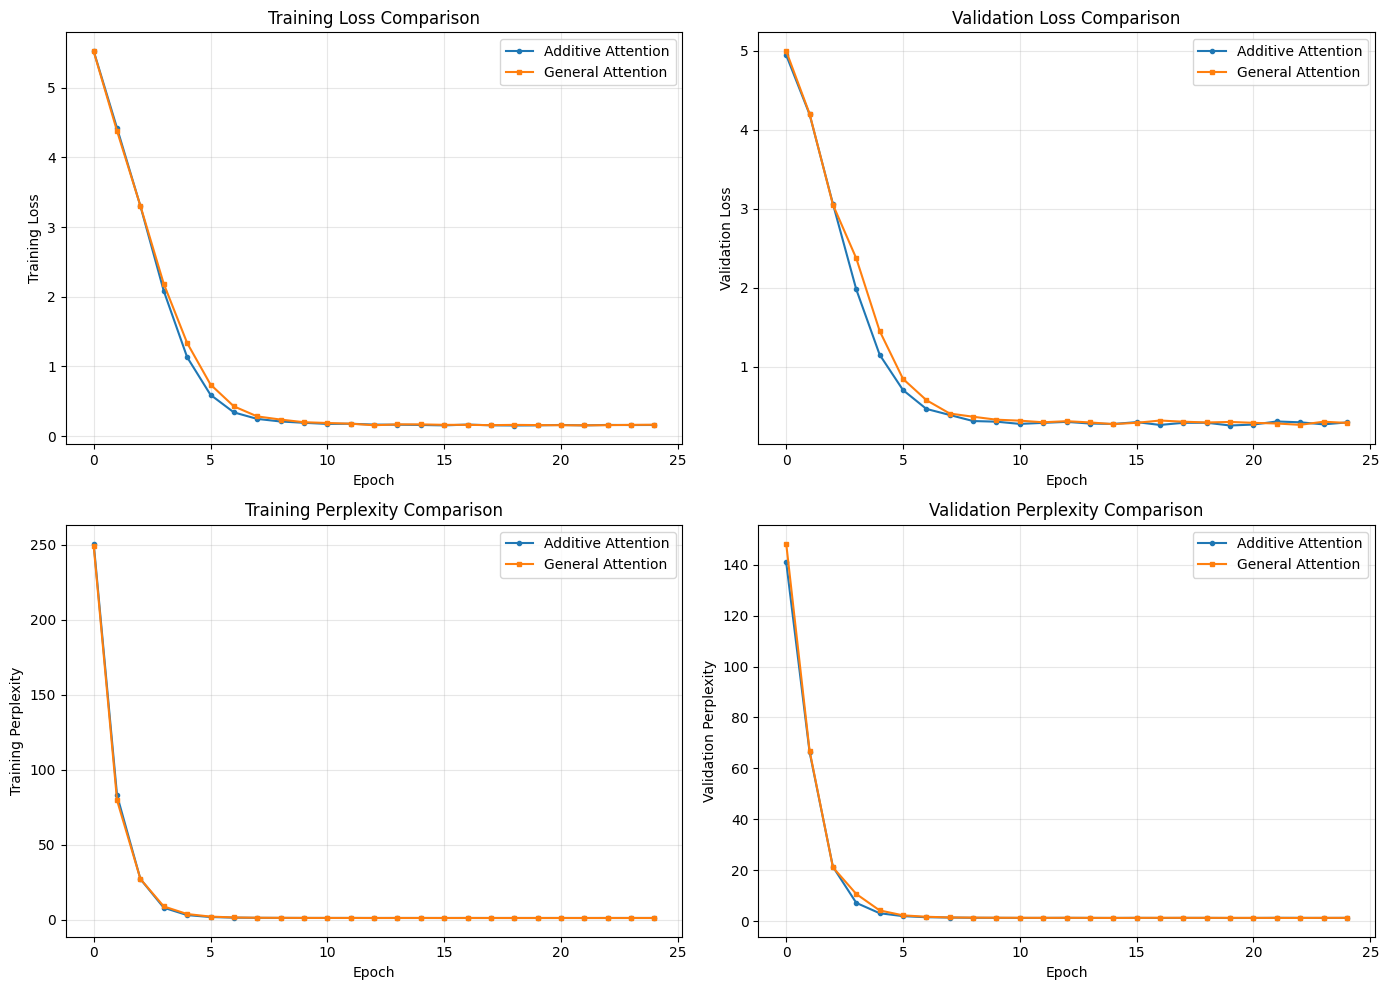


Comparison plot saved to 'attention_comparison.png'


In [15]:
# Performance Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss Comparison
axes[0, 0].plot(additive_train_losses, label='Additive Attention', marker='o', markersize=3)
axes[0, 0].plot(general_train_losses, label='General Attention', marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss Comparison
axes[0, 1].plot(additive_val_losses, label='Additive Attention', marker='o', markersize=3)
axes[0, 1].plot(general_val_losses, label='General Attention', marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Validation Loss Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training Perplexity Comparison
additive_train_ppl = [math.exp(loss) for loss in additive_train_losses]
general_train_ppl = [math.exp(loss) for loss in general_train_losses]
axes[1, 0].plot(additive_train_ppl, label='Additive Attention', marker='o', markersize=3)
axes[1, 0].plot(general_train_ppl, label='General Attention', marker='s', markersize=3)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Training Perplexity')
axes[1, 0].set_title('Training Perplexity Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Perplexity Comparison
additive_val_ppl = [math.exp(loss) for loss in additive_val_losses]
general_val_ppl = [math.exp(loss) for loss in general_val_losses]
axes[1, 1].plot(additive_val_ppl, label='Additive Attention', marker='o', markersize=3)
axes[1, 1].plot(general_val_ppl, label='General Attention', marker='s', markersize=3)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Perplexity')
axes[1, 1].set_title('Validation Perplexity Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('attention_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison plot saved to 'attention_comparison.png'")

## Performance Comparison Table

In [16]:
# Performance Comparison Table (Task 3)
print("Performance Comparison: Additive vs General Attention")

print("\n{:<20} {:<15} {:<15} {:<15} {:<15}".format(
    "Attention Type", "Train Loss", "Train PPL", "Val Loss", "Val PPL"))
print("-"*70)

print("{:<20} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}".format(
    "Additive (Bahdanau)",
    additive_train_losses[-1],
    math.exp(additive_train_losses[-1]),
    additive_val_losses[-1],
    math.exp(additive_val_losses[-1])))

print("{:<20} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}".format(
    "General",
    general_train_losses[-1],
    math.exp(general_train_losses[-1]),
    general_val_losses[-1],
    math.exp(general_val_losses[-1])))

print("Test Set Evaluation  :")
print(f"{'Additive Attention:':<25} Test Loss = {additive_test_loss:.3f}, Test PPL = {math.exp(additive_test_loss):.3f}")
print(f"{'General Attention:':<25} Test Loss = {general_test_loss:.3f}, Test PPL = {math.exp(general_test_loss):.3f}")

# Determine winner
if additive_test_loss < general_test_loss:
    winner = "Additive (Bahdanau) Attention"
    diff = ((math.exp(general_test_loss) - math.exp(additive_test_loss)) / math.exp(general_test_loss)) * 100
else:
    winner = "General Attention"
    diff = ((math.exp(additive_test_loss) - math.exp(general_test_loss)) / math.exp(additive_test_loss)) * 100

print(f"Best model: {winner}")
print(f"(Lower perplexity is better - {diff:.1f}% improvement)")

Performance Comparison: Additive vs General Attention

Attention Type       Train Loss      Train PPL       Val Loss        Val PPL        
----------------------------------------------------------------------
Additive (Bahdanau)  0.160           1.174           0.292           1.339          
General              0.163           1.178           0.285           1.330          
Test Set Evaluation  :
Additive Attention:       Test Loss = 0.260, Test PPL = 1.297
General Attention:        Test Loss = 0.267, Test PPL = 1.307
Best model: Additive (Bahdanau) Attention
(Lower perplexity is better - 0.8% improvement)


## Attention Visualization

In [17]:
def translate_sentence_attention(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    
    tokens = sentence.split()
    ids = [src_vocab.get(token, src_vocab['<unk>']) for token in tokens]
    ids = [src_vocab['<sos>']] + ids + [src_vocab['<eos>']]
    
    src_tensor = torch.LongTensor(ids).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(ids)]).to(device)
    
    idx_to_word = {idx: word for word, idx in trg_vocab.items()}
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    
    mask = model.create_mask(src_tensor)
    trg_idx = trg_vocab['<sos>']
    
    translated_tokens = []
    attentions_list = []
    
    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_idx]).to(device)
        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        
        pred_token = output.argmax(1).item()
        translated_tokens.append(idx_to_word.get(pred_token, '<unk>'))
        attentions_list.append(attention.squeeze(0).cpu())
        
        if pred_token == trg_vocab['<eos>']:
            break
        
        trg_idx = pred_token
    
    return translated_tokens, attentions_list

def display_attention(sentence, translation, attention_weights):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    attention = torch.stack(attention_weights).numpy()
    
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)
    
    ax.tick_params(labelsize=10)
    
    src_tokens = ['<sos>'] + sentence.split() + ['<eos>']
    ax.set_xticklabels([''] + src_tokens, rotation=45)
    ax.set_yticklabels([''] + translation)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xlabel('Source (English)')
    plt.ylabel('Target (Urdu)')
    plt.title('Attention Weights Heatmap')
    plt.tight_layout()
    plt.show()


Visualizing attention for: 'I love you.'
Model: Additive Attention
Translation: میں تم سے پیار ہے۔


C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3774706060.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=45)
C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3774706060.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3774706060.py:60: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3774706060.py:60: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\3774706060.py:60: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\

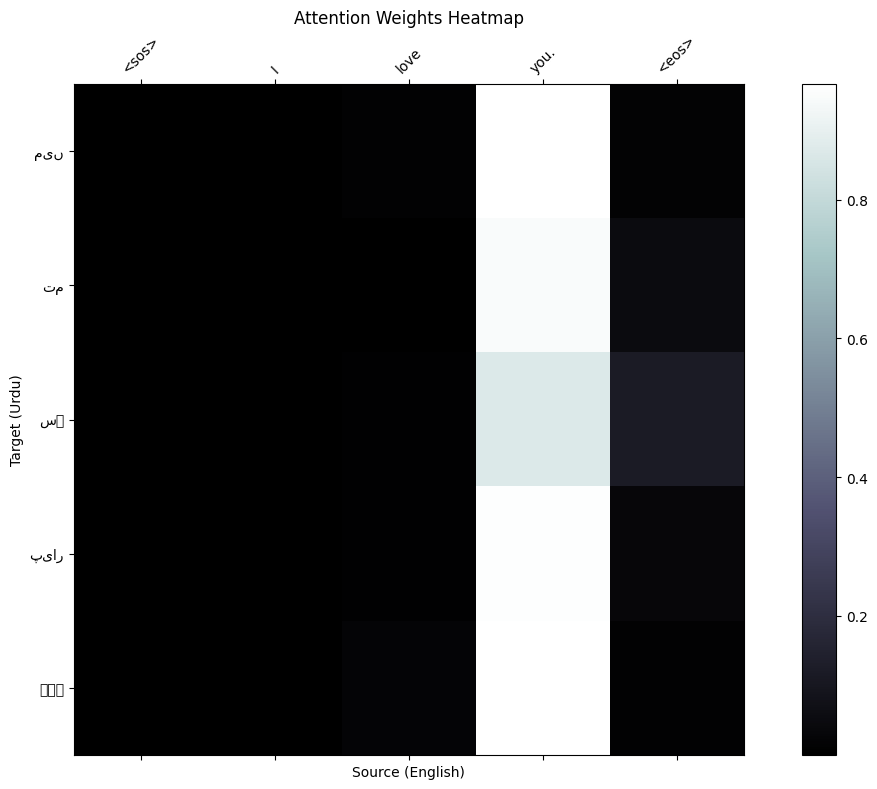

In [18]:
# Visualize attention for example sentence
example_sentence = "I love you."

# Use best model (General Attention)
if general_test_loss < additive_test_loss:
    best_model = model_general
    model_name = "General Attention"
else:
    best_model = model_additive
    model_name = "Additive Attention"

translation, attentions = translate_sentence_attention(example_sentence, src_vocab, trg_vocab, best_model, device)

if '<eos>' in translation:
    eos_idx = translation.index('<eos>')
    translation = translation[:eos_idx]
    attentions = attentions[:eos_idx]

print(f"\nVisualizing attention for: '{example_sentence}'")
print(f"Model: {model_name}")
print(f"Translation: {' '.join(translation)}")

display_attention(example_sentence, translation, attentions)

## Sample Translations

In [19]:
# Test translations with best model
test_sentences = [
    "I love you.",
    "How are you?",
    "Good job!",
    "I am a student.",
    "We won.",
    "Thank you."
]

print(f"\nSample Translations using {model_name}:")

for sent in test_sentences:
    try:
        translation, _ = translate_sentence_attention(sent, src_vocab, trg_vocab, best_model, device)
        if '<eos>' in translation:
            translation = translation[:translation.index('<eos>')]
        print(f"\nEN: {sent}")
        print(f"UR: {' '.join(translation)}")
    except Exception as e:
        print(f"\nEN: {sent}")
        print(f"UR: [Translation Error: {str(e)}]")


Sample Translations using Additive Attention:

EN: I love you.
UR: میں تم سے پیار ہے۔

EN: How are you?
UR: آپ کا کیا حال ہے ؟

EN: Good job!
UR: پہت خوب۔

EN: I am a student.
UR: میں ایک طالب علم ہوں۔

EN: We won.
UR: ہم جیت گئے۔

EN: Thank you.
UR: وہ زیادہ ذہین ہے۔


---

# Bonus: Transformer Model

## Transformer Architecture

In [20]:
class PositionalEncoding(nn.Module):    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model=256, nhead=8, 
                 num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512,
                 dropout=0.1, src_pad_idx=1, trg_pad_idx=1):
        super().__init__()
        
        self.d_model = d_model
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=src_pad_idx)
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model, padding_idx=trg_pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        
        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.src_embedding.weight.data.uniform_(-initrange, initrange)
        self.trg_embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)
    
    def make_src_mask(self, src):
        src_mask = (src == self.src_pad_idx).transpose(0, 1)
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_len = trg.shape[0]
        trg_mask = torch.triu(torch.ones(trg_len, trg_len), diagonal=1).bool().to(trg.device)
        trg_padding_mask = (trg == self.trg_pad_idx).transpose(0, 1)
        return trg_mask, trg_padding_mask
    
    def forward(self, src, trg):
        src_padding_mask = self.make_src_mask(src)
        trg_mask, trg_padding_mask = self.make_trg_mask(trg)
        
        src_embedded = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.d_model))
        trg_embedded = self.pos_encoder(self.trg_embedding(trg) * math.sqrt(self.d_model))
        
        output = self.transformer(
            src_embedded,
            trg_embedded,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
            tgt_key_padding_mask=trg_padding_mask,
            memory_key_padding_mask=src_padding_mask
        )
        
        output = self.fc_out(output)
        return output

In [21]:
# Initialize Transformer model
D_MODEL = 256
NHEAD = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT_TRANSFORMER = 0.1

model_transformer = TransformerModel(
    INPUT_DIM, OUTPUT_DIM, D_MODEL, NHEAD,
    NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
    DIM_FEEDFORWARD, DROPOUT_TRANSFORMER,
    PAD_IDX, PAD_IDX
).to(device)

print(f'Transformer has {count_parameters(model_transformer):,} trainable parameters')

Transformer has 5,297,596 trainable parameters


c:\Users\mfaha\miniconda3\envs\cuda_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [22]:
def train_epoch_transformer(model, loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for src, trg in loader:
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg[:-1, :])
        
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

def evaluate_transformer(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, trg in loader:
            src = src.to(device)
            trg = trg.to(device)
            
            output = model(src, trg[:-1, :])
            
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

In [23]:
# Train Transformer
print("Training - Transformer Model")

optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
best_val_loss_transformer = float('inf')
transformer_train_losses = []
transformer_val_losses = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch_transformer(model_transformer, train_loader_transformer, optimizer_transformer, criterion, CLIP)
    val_loss = evaluate_transformer(model_transformer, val_loader_transformer, criterion)
    
    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) - (epoch_mins * 60))
    
    transformer_train_losses.append(train_loss)
    transformer_val_losses.append(val_loss)
    
    if val_loss < best_val_loss_transformer:
        best_val_loss_transformer = val_loss
        torch.save(model_transformer.state_dict(), 'models/transformer_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')

Training - Transformer Model
Epoch: 01 | Time: 0m 5s
	Train Loss: 4.762 | Train PPL: 116.940
	 Val. Loss: 2.995 |  Val. PPL:  19.982
Epoch: 02 | Time: 0m 5s
	Train Loss: 2.392 | Train PPL:  10.930
	 Val. Loss: 1.251 |  Val. PPL:   3.494
Epoch: 03 | Time: 0m 4s
	Train Loss: 1.102 | Train PPL:   3.010
	 Val. Loss: 0.452 |  Val. PPL:   1.572
Epoch: 04 | Time: 0m 4s
	Train Loss: 0.469 | Train PPL:   1.598
	 Val. Loss: 0.171 |  Val. PPL:   1.187
Epoch: 05 | Time: 0m 4s
	Train Loss: 0.235 | Train PPL:   1.265
	 Val. Loss: 0.107 |  Val. PPL:   1.113
Epoch: 06 | Time: 0m 4s
	Train Loss: 0.157 | Train PPL:   1.170
	 Val. Loss: 0.092 |  Val. PPL:   1.097
Epoch: 07 | Time: 0m 4s
	Train Loss: 0.128 | Train PPL:   1.136
	 Val. Loss: 0.081 |  Val. PPL:   1.085
Epoch: 08 | Time: 0m 4s
	Train Loss: 0.113 | Train PPL:   1.120
	 Val. Loss: 0.083 |  Val. PPL:   1.087
Epoch: 09 | Time: 0m 4s
	Train Loss: 0.101 | Train PPL:   1.107
	 Val. Loss: 0.084 |  Val. PPL:   1.087
Epoch: 10 | Time: 0m 5s
	Train Loss

In [24]:
# Evaluate Transformer
model_transformer.load_state_dict(torch.load('models/transformer_model.pt'))
transformer_test_loss = evaluate_transformer(model_transformer, test_loader_transformer, criterion)
print(f'Transformer - Test Loss: {transformer_test_loss:.3f} | Test PPL: {math.exp(transformer_test_loss):.3f}')

C:\Users\mfaha\AppData\Local\Temp\ipykernel_23496\2178399150.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transformer.load_state_dict(torch.load('models/transfo

Transformer - Test Loss: 0.056 | Test PPL: 1.058


---

# Final Results Summary

In [26]:
print("Final Results: All Models Comparison")

print(f"\nDataset: Tatoeba English-Urdu Parallel Corpus")
print(f"  Train: {len(train_data)} pairs")
print(f"  Val:   {len(val_data)} pairs")
print(f"  Test:  {len(test_data)} pairs")

print(f"\nVocabulary:")
print(f"  English: {len(src_vocab)} tokens")
print(f"  Urdu:    {len(trg_vocab)} tokens")

print("Model Comparison Table")
print(f"{'Model':<25} {'Parameters':<15} {'Train Loss':<12} {'Val Loss':<12} {'Test PPL':<12}")
print(f"{'Additive Attention':<25} {count_parameters(model_additive):<15,} {additive_train_losses[-1]:<12.3f} {additive_val_losses[-1]:<12.3f} {math.exp(additive_test_loss):<12.3f}")
print(f"{'General Attention':<25} {count_parameters(model_general):<15,} {general_train_losses[-1]:<12.3f} {general_val_losses[-1]:<12.3f} {math.exp(general_test_loss):<12.3f}")
print(f"{'Transformer':<25} {count_parameters(model_transformer):<15,} {transformer_train_losses[-1]:<12.3f} {transformer_val_losses[-1]:<12.3f} {math.exp(transformer_test_loss):<12.3f}")

# Find overall best
all_test_losses = {
    'Additive Attention': additive_test_loss,
    'General Attention': general_test_loss,
    'Transformer': transformer_test_loss
}
best_model_name = min(all_test_losses, key=all_test_losses.get)

print(f"\nOverall Best Model: {best_model_name}")
print(f"Test Perplexity: {math.exp(all_test_losses[best_model_name]):.3f}")

Final Results: All Models Comparison

Dataset: Tatoeba English-Urdu Parallel Corpus
  Train: 7352 pairs
  Val:   2100 pairs
  Test:  1051 pairs

Vocabulary:
  English: 1791 tokens
  Urdu:    1724 tokens
Model Comparison Table
Model                     Parameters      Train Loss   Val Loss     Test PPL    
Additive Attention        10,424,764      0.160        0.292        1.297       
General Attention         10,161,084      0.163        0.285        1.307       
Transformer               5,297,596       0.065        0.061        1.058       

Overall Best Model: Transformer
Test Perplexity: 1.058
